# 根据质心距离合并标签
在这个笔记本中，我们将根据标签之间的质心距离来合并标签图像中的标签。相互靠近的标签将被合并。

另请参阅
* [Image.sc 讨论](https://forum.image.sc/t/measure-distances-between-labels/79125)
* [使用 napari-accelerated-pixel-and-object-classifiers 合并标签](https://github.com/haesleinhuepf/napari-accelerated-pixel-and-object-classification#merging-objects)

In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread

为了演示目的，我们使用了从斑点示例图像派生的标签的修改版本。我们人为地在它们之间引入了间隙。

cl.OCLArray([[ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
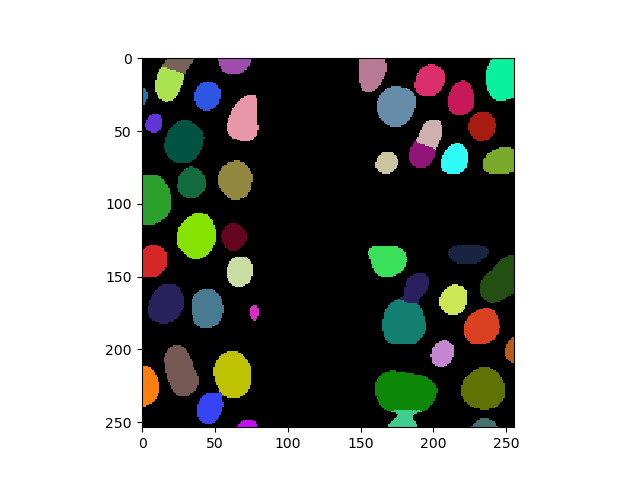

In [2]:
image = imread("../../data/blobs.tif")
image[:, 80:150] = 0
image[80:130, 100:] = 0

image = cle.asarray(image)
labels = cle.voronoi_otsu_labeling(image, spot_sigma=4, outline_sigma=3)
labels

从这个图像中，我们提取质心的坐标。从这些质心，我们可以构建一个距离矩阵。在这个矩阵中，计算了所有质心到所有其他质心的距离。对角线为零，因为它对应于一个质心到自身的距离。此外，到背景的距离（第一行和第一列）也为零，因为在距离计算中不考虑背景。

cl.OCLArray([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 199.36461 , ..., 245.29527 , 274.9624  ,
        306.2263  ],
       [  0.      , 199.36461 ,   0.      , ..., 321.00064 , 250.97119 ,
        249.23108 ],
       ...,
       [  0.      , 245.29527 , 321.00064 , ...,   0.      , 139.21213 ,
        186.94691 ],
       [  0.      , 274.9624  , 250.97119 , ..., 139.21213 ,   0.      ,
         48.239468],
       [  0.      , 306.2263  , 249.23108 , ..., 186.94691 ,  48.239468,
          0.      ]], dtype=float32)
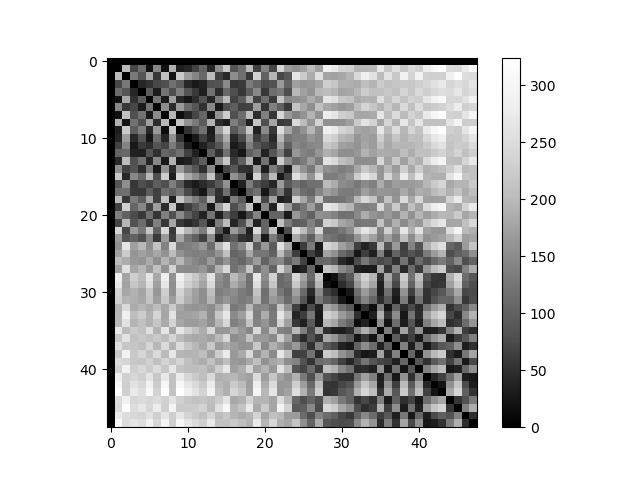
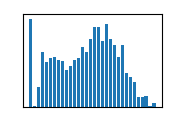

In [3]:
centroids = cle.centroids_of_labels(labels)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)
distance_matrix

我们可以用给定的最大距离对这个距离矩阵进行阈值处理。结果是一个二元矩阵。

cl.OCLArray([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]], dtype=uint8)
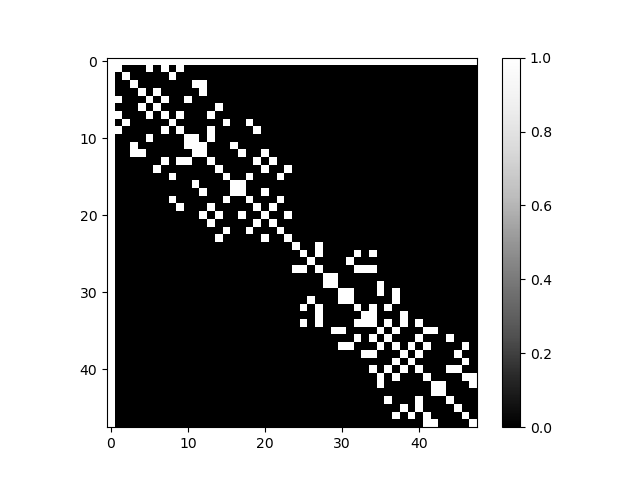
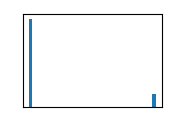

In [4]:
maximum_distance = 40

merge_matrix = distance_matrix <= maximum_distance
merge_matrix

如果我们将标签与背景合并，所有标签都会被合并，因为它们都接触背景。为了防止这种情况，我们将第一行和第一列设置为零。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)
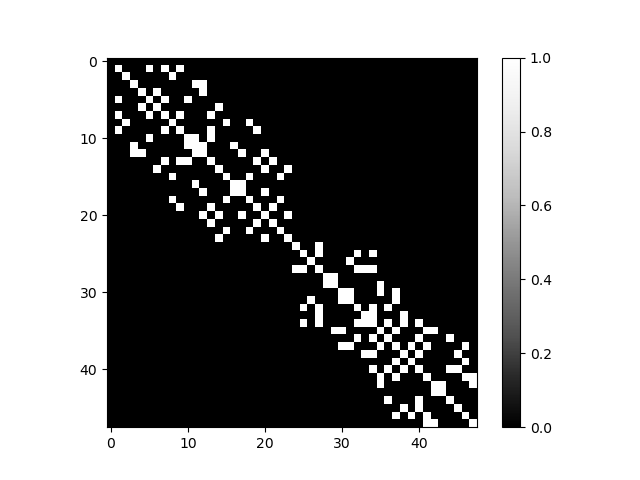
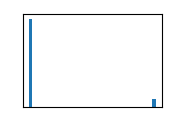

In [5]:
cle.set_column(merge_matrix, 0, 0)
cle.set_row(merge_matrix, 0, 0)

merge_matrix

使用上面的二元矩阵，我们现在可以相应地合并标签。

cl.OCLArray([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
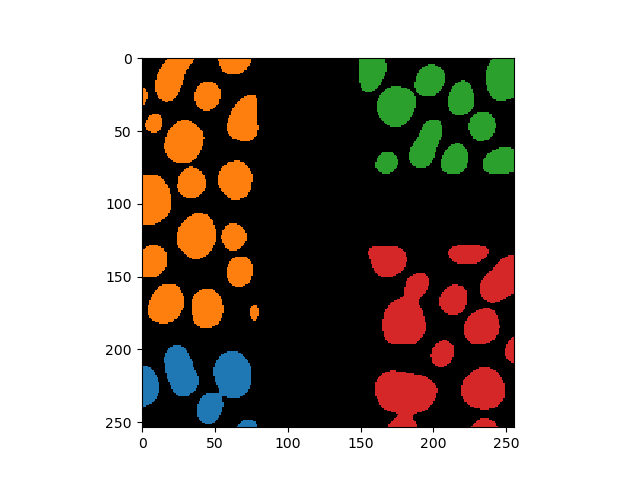

In [6]:
merged_labels = cle.merge_labels_according_to_touch_matrix(labels, merge_matrix)
merged_labels